In [1]:
import abc
import copy
from collections import *
from dataclasses import *
import random
from typing import *

from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim


# In order to make the import of local modules
import sys
sys.path.append('.')

# local modules
from ultimate_tic_tac_toe_2 import *

In [2]:
"""
An environment for the Ultimate Tic Tac Toe, for an agent to play against
"""


class TicTacToeEnv:
    def __init__(self, opponent: Union[Agent, List[Agent]]):
        self.game: Board = Board.empty()
        self.player = CROSS
        self.opponent = CIRCLE
        if isinstance(opponent, Agent):
            self.opponent_agents: List[Agent] = [opponent]
        else:
            self.opponent_agents: List[Agent] = list(opponent)
        self.opponent_agent = random.choice(self.opponent_agents)
        
    def reset(self):
        self.opponent_agent.on_end_episode()
        self.game = Board.empty()
        self.player = random.choice([CROSS, CIRCLE])
        self.opponent = next_player(self.player)
        self.opponent_agent = random.choice(self.opponent_agents)
        if self.player == CIRCLE:  # Cross always start first
            move = self.opponent_agent.get_action(self.game, self.opponent)
            self.game = self.game.play(self.opponent, move)
        return self.state
    
    @property
    def state(self):
        return self.game.grid, self.player
    
    def is_over(self):
        return self.game.is_over()
    
    def step(self, move: Move) -> Reward:
        self.game = self.game.play(self.player, move)
        self.opponent_agent.on_opponent_action(move, self.player)
        if self.game.is_over():
            return self._reward()
        
        # TODO - should notify of the main agent of the action that has been done by other player?
        move = self.opponent_agent.get_action(self.game, self.opponent)
        self.game = self.game.play(self.opponent, move)
        return self._reward()
    
    def _reward(self):
        if self.game.winner == self.player:
            return 1
        elif self.game.winner == self.opponent:
            return -1
        else:
            return 0

In [3]:
"""
To simulate a constest between agents
"""
    
# TODO - find a way to watch it play

    
def play_episode(env, agent, with_log=False):
    total_reward = 0.
    env.reset()
    while not env.is_over():
        if with_log:
            print(env.game.grid)
        move = agent.get_action(env.game, env.player)
        reward = env.step(move)
        total_reward += reward
    if with_log:
        print(env.game.grid)
    return total_reward, env.state


@dataclass(frozen=False)
class Stats:
    win: float
    draw: float
    loss: float
    
    def score(self):
        return self.win - self.loss

        
def get_stats(env, agent, counts=100):
    stats = defaultdict(int)
    for _ in range(counts):
        result, _ = play_episode(env, agent)
        stats[result] += 1 
    return Stats(
        win=stats[1.0] / counts * 100,
        draw=stats[0.0] / counts * 100,
        loss=stats[-1.0] / counts * 100)
        

def try_out(env, agent):
    stats = get_stats(env, agent)
    print("* win:", stats.win, "%")
    print("* draw:", stats.draw, "%")
    print("* loss:", stats.loss, "%")


"""
Contest between agents
"""
    
    
print("Basic stats: first move (agent) vs random (env)")
try_out(env=TicTacToeEnv(opponent=RandomAgent()), agent=FirstMoveAgent())

print("Basic stats: random (agent) vs first move (env)")
try_out(env=TicTacToeEnv(opponent=FirstMoveAgent()), agent=RandomAgent())

Basic stats: first move (agent) vs random (env)
* win: 71.0 %
* draw: 4.0 %
* loss: 25.0 %
Basic stats: random (agent) vs first move (env)
* win: 32.0 %
* draw: 0.0 %
* loss: 68.0 %


In [4]:
# TODO - missing some inputs here for the next quadrant (perhaps encode it inside the positions, that would be better)
# TODO - if you encode inside the positions, then you can use convolution layers
# TODO - try to learn a value function in order for MCTS to perform better


"""
Now trying to learn an approximate policy, based on Neural Nets
"""


class Policy(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(in_features=len(ALL_COORDINATES)+2, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=len(ALL_COORDINATES)))
    
    def forward(self,
                grid: Union[torch.FloatTensor, np.ndarray],
                player: Union[PlayerId, List[PlayerId]]):
        
        # Transforming the grids to valid inputs
        if isinstance(grid, np.ndarray):
            xs = torch.FloatTensor(grid)
        else:
            xs = grid
        if len(xs.shape) == 2:
            xs = xs.unsqueeze(dim=0)
        batch_size, h, w = xs.shape
        xs = xs.reshape((batch_size, h * w))
        
        # Transforming the players to valid inputs
        if isinstance(player, list):
            ys = torch.zeros(size=(batch_size, 2), dtype=torch.float32)
            for i, p in enumerate(player):
                if p == CROSS:
                    ys[i,0] = 1
                else:
                    ys[i,1] = 0
        else:
            ys = torch.zeros(size=(batch_size, 2), dtype=torch.float32)
            if player == CROSS:
                ys[:,0] = 1
            else:
                ys[:,1] = 0
        
        xs = torch.cat((xs, ys), dim=-1)
        xs = self.fc(xs)
        return xs
    
    def clone(self):
        cloned = Policy()
        cloned.load_state_dict(self.state_dict())
        return cloned


"""
Packaging the policy into an Agent
"""


class PolicyAgent(Agent):
    def __init__(self, policy: nn.Module):
        self.policy = policy
        self.policy.eval()

    def get_action(self, game: Board, player: PlayerId) -> Move:
        action_values = self.policy(game.grid, player=player)
        return best_of_available_moves(game, action_values)

100%|██████████| 1000/1000 [01:27<00:00, 11.46it/s]


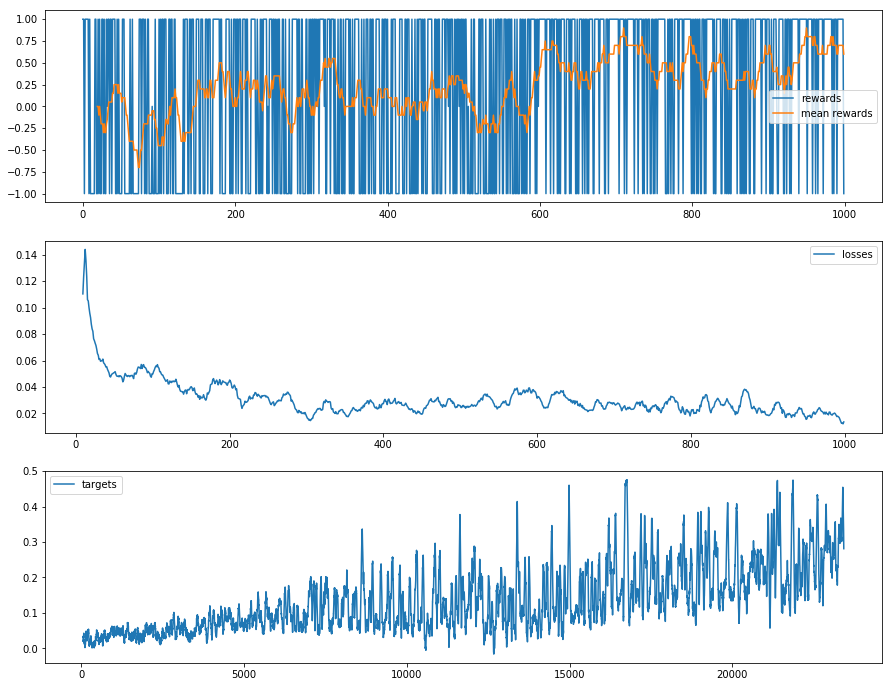

In [6]:
"""
SARSA with replay buffer, using Deep Learning techniques

Solved:
- the deadly triad (bootstrapping + appoximation + off-policy) is respected: the Q-values should converge 
- the replay buffer allows to approach the notion of i.i.d. (independent and identically distributed)

Problems:
- the learned policy includes the epsilon (but we can reduce the epsilon)
- the output of the policy is a single number that mixes 3 concepts: draw, win, loss probabilities
"""


def mask_invalid_actions(game: Board, action_values: torch.Tensor) -> torch.Tensor:
    available = set(game.available_moves)
    mask = torch.zeros(size=(1,9*9), dtype=torch.uint8)
    for i, move in enumerate(ALL_COORDINATES):
        if move in available:
            mask[(0, i)] = 1
    action_values[~mask] = -100. # Invalid actions get a strong penalty (and since it converges, it works)
    return action_values


def best_of_available_moves(game: Board, action_values: torch.Tensor) -> Move:
    action_probs_masked = mask_invalid_actions(game, action_values)
    _, i = torch.max(action_probs_masked, dim=-1)
    return ALL_COORDINATES[i]

    
def epsilon_greedy_action(policy, game, player: PlayerId, epsilon) -> Tuple[Move, Reward]:
    # Epsilon greedy action
    # Note that it would not be correct to use a softmax on the Q-values
    # => you should go for policy gradient algorithms to do this
    action_values = policy(game.grid, player)
    if np.random.rand(1) < epsilon:
        move = random.choice(game.available_moves)
    else:
        move = best_of_available_moves(game, action_values)
    return move, action_values[(0, ALL_COORDINATES.index(move))]


def train_sarsa_policy_batch(
    env, policy: nn.Module, episodes: int, discount: float,
    start_epsilon: float, min_epsilon: float, epsilon_decrease: float,
    learning_rate: float, learning_rate_decay: float,
    weight_decay: float,
    replay_buffer=1000, min_replay_buffer=100, minibatch_size=32,
    show_stats=True):
    
    policy.train()
    episode_rewards = []
    episode_losses = []
    target_values = []
    epsilon = start_epsilon

    criterion = nn.MSELoss()
    optimizer = optim.Adam(policy.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=learning_rate_decay)

    replay_buffer = deque(maxlen=replay_buffer)
    
    for episode in trange(episodes):
        episode_loss = 0.
        episode_reward = 0.
        
        # For double learning (stability of the Q-values)
        '''
        if episode % 100 == 0:
            ref_policy = policy.clone()
        '''
        
        env.reset()
        optimizer.zero_grad() # in case of eligibility traces
        move, move_value = epsilon_greedy_action(policy, env.game, env.player, epsilon)

        while not env.is_over():
            game = env.game
            reward = env.step(move)
            
            # Get the target value
            next_game = env.game
            if next_game.is_over():
                if env.game.winner == env.player:
                    epsilon = max(min_epsilon, epsilon_decrease * epsilon)
                target_value = reward
            else:
                next_move, next_move_value = epsilon_greedy_action(policy, next_game, env.player, epsilon)
                # next_move, next_move_value = epsilon_greedy_action(ref_policy, next_game, env.player, epsilon)
                target_value = reward + discount * next_move_value.item()
            
            # Store the current move and target in the replay buffer
            replay_buffer.append((game.grid, env.player, ALL_COORDINATES.index(move), target_value))

            # Sample a minibatch from the replay buffer
            if len(replay_buffer) >= min_replay_buffer:
                
                # TODO - encode the symetries (rotate the board + the move... should stay the same)
                
                gs = []
                ps = []
                ms = []
                ts = []
                for i, (g, p, m, t) in enumerate(random.choices(replay_buffer, k=minibatch_size)):
                    gs.append(g)
                    ps.append(p)
                    ms.append((i, m))
                    ts.append(t)
                gs = torch.FloatTensor(np.stack(gs))
                ts = torch.FloatTensor(ts)
                
                out = policy(gs, ps)
                out = torch.stack([out[m] for m in ms])
            
                # Calculate loss & Update policy
                optimizer.zero_grad()
                loss = criterion(out, ts)
                loss.backward()
                optimizer.step()
                episode_loss += loss.item()

            # Record history
            episode_reward += reward
            target_values.append(target_value)
            
            # Next iteration
            if not next_game.is_over():
                move = next_move
                move_value = next_move_value
        
        # Record history
        episode_rewards.append(episode_reward)
        episode_losses.append(episode_loss)
    
    # Reporting
    if show_stats:
        fig, ax = plt.subplots(figsize=(15, 12), nrows=3)
        ax[0].plot(episode_rewards, label="rewards")
        ax[0].plot(pd.Series(episode_rewards).rolling(20).mean(), label="mean rewards")
        ax[1].plot(pd.Series(episode_losses).rolling(10).sum() / 100., label="losses")
        ax[2].plot(pd.Series(target_values).rolling(50).sum() / 100., label="targets")
        for p in ax:
            p.legend()
        plt.show()
    
    
"""
Training against the basic agents
"""

sarsa_policy_1 = Policy()
train_sarsa_policy_batch(
    env=TicTacToeEnv(opponent=[FirstMoveAgent(), RandomAgent()]),
    policy=sarsa_policy_1, episodes=1000, discount=0.99,
    start_epsilon=0.9, min_epsilon=0.001, epsilon_decrease=0.95,
    learning_rate=1e-4, learning_rate_decay=0.99,
    weight_decay=1e-4,
    replay_buffer=1000, min_replay_buffer=100, minibatch_size=32)

In [7]:
"""
Trying the agent against various opponents
"""

print("- Try against the first move agent:")
try_out(env=TicTacToeEnv(opponent=FirstMoveAgent()), agent=PolicyAgent(sarsa_policy_1))

print("- Try against the random move agent:")
try_out(env=TicTacToeEnv(opponent=RandomAgent()), agent=PolicyAgent(sarsa_policy_1))

print("- Try against the minimax agent:")
minimax = MinimaxAgent(max_depth=2, eval_fct=CountOwnedEvaluation())
try_out(env=TicTacToeEnv(opponent=minimax), agent=PolicyAgent(sarsa_policy_1))

- Try against the first move agent:
* win: 100.0 %
* draw: 0.0 %
* loss: 0.0 %
- Try against the random move agent:
* win: 56.00000000000001 %
* draw: 1.0 %
* loss: 43.0 %
- Try against the minimax agent:
* win: 0.0 %
* draw: 0.0 %
* loss: 100.0 %


100%|██████████| 5000/5000 [12:50<00:00,  6.53it/s]


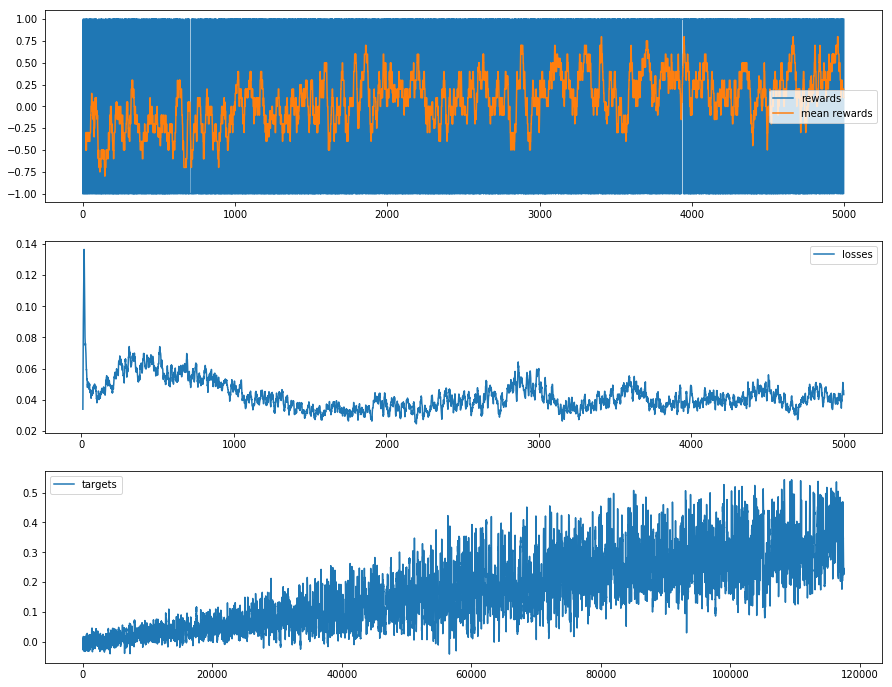

In [10]:
"""
Training against more complex agents
"""

minimax1 = MinimaxAgent(max_depth=2, eval_fct=CountOwnedEvaluation())
minimax2 = MinimaxAgent(max_depth=2, eval_fct=PriceMapEvaluation())

sarsa_policy_2 = Policy()
train_sarsa_policy_batch(
    env=TicTacToeEnv(opponent=[FirstMoveAgent(), LastMoveAgent(), RandomAgent(), minimax1, minimax2]),
    policy=sarsa_policy_2, episodes=5000, discount=0.99,
    start_epsilon=0.9, min_epsilon=0.01, epsilon_decrease=0.99,
    learning_rate=1e-4, learning_rate_decay=0.99,
    weight_decay=1e-4,
    replay_buffer=5000, min_replay_buffer=200, minibatch_size=32)

In [13]:
"""
Trying the agent against various opponents
"""

print("- Try against the first move agent:")
try_out(env=TicTacToeEnv(opponent=FirstMoveAgent()), agent=PolicyAgent(sarsa_policy_2))

print("- Try against the last move agent:")
try_out(env=TicTacToeEnv(opponent=LastMoveAgent()), agent=PolicyAgent(sarsa_policy_2))

print("- Try against the random move agent:")
try_out(env=TicTacToeEnv(opponent=RandomAgent()), agent=PolicyAgent(sarsa_policy_2))

print("- Try against the minimax agent 1:")
try_out(env=TicTacToeEnv(opponent=minimax1), agent=PolicyAgent(sarsa_policy_2))

print("- Try against the minimax agent 2:")
try_out(env=TicTacToeEnv(opponent=minimax2), agent=PolicyAgent(sarsa_policy_2))

- Try against the first move agent:
* win: 100.0 %
* draw: 0.0 %
* loss: 0.0 %
- Try against the last move agent:
* win: 100.0 %
* draw: 0.0 %
* loss: 0.0 %
- Try against the random move agent:
* win: 50.0 %
* draw: 2.0 %
* loss: 48.0 %
- Try against the minimax agent 1:
* win: 50.0 %
* draw: 0.0 %
* loss: 50.0 %
- Try against the minimax agent 2:
* win: 56.00000000000001 %
* draw: 0.0 %
* loss: 44.0 %


In [ ]:
# TODO - play against the minimax agent
# TODO - play against the MCTS agent
# TODO - policy gradient learning
# TODO - supervised learning based on plays by the minimax agent?
# TODO - try to summarize a big MCTS on the neural net?